In [1]:
import os
import sys
# block warnings from printing
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import collections
import xarray as xr
xr.set_options(keep_attrs=True)
import netCDF4 as nc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import metpy.calc as mp
from metpy.units import units
from scipy.stats import ttest_ind, ttest_rel
from datetime import datetime

import cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean.cm as cmo


# add path to custom functions
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/py_functions")
# import custom functions
from map_plot_tools import *
from colorbar_funcs import *


# settings
%config InlineBackend.figure_format = 'retina'


In [2]:
### +++ FUNCTIONS +++ ###

## TIME-SERIES MEAN SEASONAL CLIMATOLOGIES ##
def season_mean(ds, calendar='standard'):
    seas_mean = ds.groupby('time.season').mean(dim='time') #sum(dim='time')
    return seas_mean

## ANNUAL SEASONAL MEAN CLIMATOLOGIES ##
def annual_season_mean(ds, calendar='standard'):
    ds_seasonal = {}
    ann_seasonal_mean = {}
    for season in ['DJF','MAM','JJA','SON']:
        # extract data for season
        ds_seasonal[season] = ds.where(ds['time.season'] == season)
        # I'm not sure what this step is doing
        if season == 'DJF':
            ds_seasonal[season] = ds_seasonal[season].shift(time=1)
        # get timeseries of seasonal mean climatologies
        ann_seasonal_mean[season] = ds_seasonal[season].groupby('time.year').mean(dim='time') #sum(dim='time')
        # but, cut first year of DJF timeseries as there is no Dec data from year -1
        if season == 'DJF':
            year_min = ann_seasonal_mean[season].year.min()+1
            year_max = ann_seasonal_mean[season].year.max()
            ann_seasonal_mean[season] = ann_seasonal_mean[season].sel(year=slice(year_min, year_max)) #.isel(year=slice(1,len(ann_seas_mean['DJF'].year)))
    return ann_seasonal_mean


## STATISTICAL SIGNIFICANCE TEST ##
# test with identical sample sizes
def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals

# test with different sample sizes
def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals


In [3]:
### +++ DATA PATHS +++ ###

runNames=['E2pt1_PIctrl_restart', 'cam.1senv.cpld', 'cam.sam.1senv.cpld'] # E2.1 cpld simulations
keys=['ctrl', 'cam-only', 'cam+sam'] # product key
diags=['HWV','vimfc','prec'] # diagnostics

# store file paths in dictionary
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar' # top level data directory
files={}

for i,key in enumerate(keys):
    files[key] = {}
    for varn in diags:
        run=runNames[i]
        files[key][varn] = f'{dpath0}/{run}/timeseries/{varn}_timeseries.{run}.nc'
        

In [4]:
## ORGANIZE DATA AND CALCULATE CLIMATOLOGIES

# number of years to omit 
omit_yrs = 30
n_omit = omit_yrs * 12
tmax = 350 * 12
# lat lon bounds
latmin = -50
latmax = 25
lonmin = 90
lonmax = 315

# initialize dictionaries
dat = {}
time_mean = {}
seas_mean = {}
ann_seas_mean = {}

print('Working on...')
for i,key in enumerate(keys):
    print(f'{key}')
    # initialize simulation sub-dicts
    dat[key] = {}
    time_mean[key] = {}
    seas_mean[key] = {}
    ann_seas_mean[key] = {}
    
    # open diag files
    for varn in ['HWV']:
        ds = xr.open_dataset(files[key][varn], chunks={})[varn].isel(time=slice(n_omit,tmax))
        ds_clip = ds.sel(lat=slice(latmin,latmax))
        ds_flip = longitude_flip(ds_clip)
        hwv = ds_flip.sel(lon=slice(lonmin,lonmax))
        dat[key][varn] = hwv
        del ds
        del ds_clip
        del ds_flip
        # calculate time-means
        time_mean[key][varn] = dat[key][varn].mean(dim='time')
        seas_mean[key][varn] = season_mean(dat[key][varn])
        ann_seas_mean[key][varn] = annual_season_mean(dat[key][varn])
        
    for varn in ['vimfc']:
        dat[key][varn] = xr.open_dataset(files[key][varn], chunks={})['vimfc'].isel(time=slice(n_omit,tmax))
        # calculate time-means
        time_mean[key][varn] = dat[key][varn].mean(dim='time')
        seas_mean[key][varn] = season_mean(dat[key][varn])
        ann_seas_mean[key][varn] = annual_season_mean(dat[key][varn])
        
    for varn in ['prec']:
        ds = xr.open_dataset(files[key][varn], chunks={})[varn].isel(time=slice(n_omit,tmax))
        ds_clip = ds.sel(lat=slice(latmin,latmax))
        ds_flip = longitude_flip(ds_clip)
        prec = ds_flip.sel(lon=slice(lonmin,lonmax))
        dat[key][varn] = prec
        del ds
        del ds_clip
        del ds_flip
        # calculate time-means
        time_mean[key][varn] = dat[key][varn].mean(dim='time')
        seas_mean[key][varn] = season_mean(dat[key][varn])
        ann_seas_mean[key][varn] = annual_season_mean(dat[key][varn])
    
print('Done.')

Working on...
ctrl
cam-only
cam+sam
Done.


In [5]:
## ++ CALCULATE SIGNIFICANCE OF MODEL RUN DIFFERENCES & MASK ++ ##

# initialize dictionaries
diff = collections.defaultdict(dict)
diff_mask = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']
diags = ['HWV','vimfc']

## COMPARING CONTROL MODEL RUNS WITH E2.1 MODIFIED TOPOGRAPHY RUNS
# For simulations/datasets with the same number of samples
print('Significance testing for...')
for key in ['cam-only','cam+sam']:
    print(f'{key}')
    
    for varn in diags:
        # initialize simulation sub-dicts
        diff[key][varn] = {}
        diff_mask[key][varn] = {}
        ptvals[key][varn] = {}
        # calculate significance
        for season in seasons:
            diff_, diff_mask_, ptvals_ = sigtest(ann_seas_mean[key][varn][season], ann_seas_mean['ctrl'][varn][season],
                                                 seas_mean[key][varn].sel(season=season), seas_mean['ctrl'][varn].sel(season=season))
            diff[key][varn][season] = diff_
            diff_mask[key][varn][season] = diff_mask_
            ptvals[key][varn][season] = ptvals_
            
print('Done.')


Significance testing for...
cam-only
cam+sam
Done.


In [6]:
## ++ CALCULATE DIFFERENCE OF CLIMATOLOGICAL FIELDS BETWEEN OBS & MODEL RUNS ++ ##

# initialize dictionaries
mdiff = {}
seas_mdiff = {}
diags = ['HWV','vimfc','prec']

print('Calculating field differences.')

for key in ['cam-only','cam+sam']: 
    
    # initialize key sub-dicts
    mdiff[key] = {}
    seas_mdiff[key] = {}
    
    for varn in diags:
        mdiff[key][varn] = time_mean[key][varn] - time_mean['ctrl'][varn]
        seas_mdiff[key][varn] = seas_mean[key][varn] - seas_mean['ctrl'][varn]
        
print('Done.')

Calculating field differences.
Done.


## Make Figure

In [7]:
### +++ TOPOGRAPHY CONTOURS +++ ###

# e2.1 topo bc info
land_mask=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').fgrnd
default=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').zatmo
cs1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam.sam.nc').zatmo
c1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam_only.nc').zatmo  
maxtopo=xr.open_dataset(f'{dpath0}/topo_files/giss.maxtopo.nc').zatmo  
# generate topo masks
c1env_mask=c1env.where((c1env-default)>0, 0)
cs1env_mask=cs1env.where((cs1env-default)>0, 0)
maxtopo_mask=maxtopo.where((maxtopo-default)>0, 0)

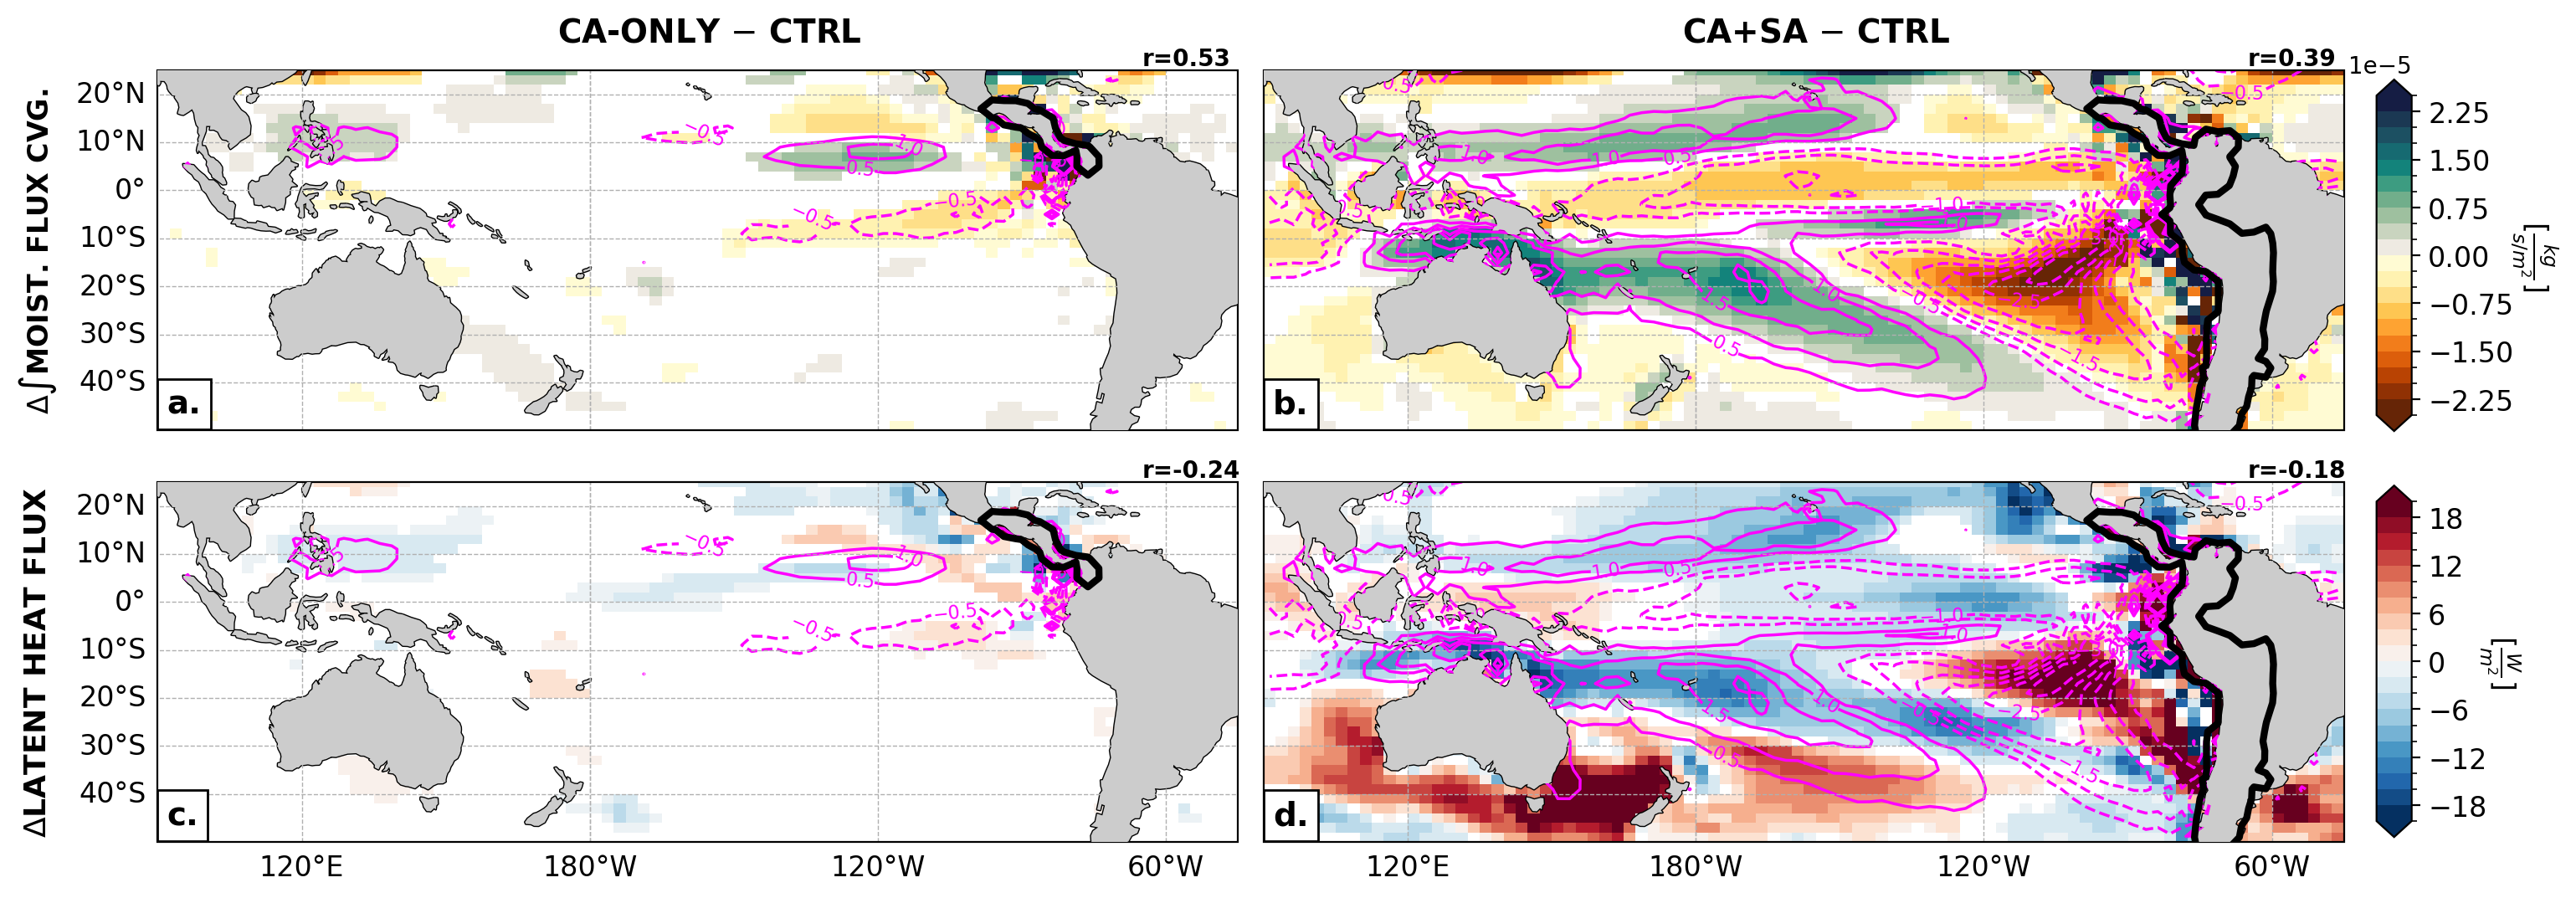

In [10]:
text_kw={'weight': 'bold', 'ha': 'center', 'va': 'center', 'color': 'black'}
text_kw2={'weight': 'bold', 'ha': 'left', 'va': 'bottom', 'color': 'black'}
arrow_kw={'arrowstyle':'|-|', 'color':'k', 'linewidth':1, 'shrinkA':0.05, 'shrinkB':0.05}
map_bnds=[90,315,-50,25]
season='MAM'
plevels=np.linspace(-4,4,13)
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=180)
lats=time_mean['ctrl']['HWV'].lat
lons=time_mean['ctrl']['HWV'].lon
mlon=c1env_mask.lon
mlat=c1env_mask.lat

fig, ax=plt.subplots(nrows=2, ncols=2, figsize=(14,5.25), constrained_layout=True, subplot_kw={'projection': proj})

## Moisture Flux Convergence
cmap,_,_,_=get_settings(field='vimfc', diff=True)
vmin=-.000025
vmax=.000025
levels=np.linspace(vmin, vmax, 21)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)

## Latent Heat Flux
cmap2,_,_,_=get_settings(field='lhf', diff=True)
vmin2=-20
vmax2=20
levels2=np.linspace(vmin2, vmax2, 21)
norm2=mpl.colors.BoundaryNorm(levels2, cmap.N)

ax[0,0].text(-115,-12.5, '$\Delta$$\int$MOIST. FLUX CVG.', rotation=90, size=12, **text_kw)
ax[1,0].text(-115,-12.5, '$\Delta$LATENT HEAT FLUX', rotation=90, size=13, **text_kw)
ax[0,0].text(25, 33, 'CA-ONLY $-$ CTRL', size=14, **text_kw)
ax[0,1].text(25, 33, 'CA+SA $-$ CTRL', size=14, **text_kw)


for key in ['cam-only']:
    ax[0,0].pcolormesh(lons, lats, diff_mask[key]['vimfc'][season], cmap=cmap, norm=norm, transform=trans)
    ax[0,0].text(115,26, 'r=0.53', size=10, ha='left', weight='bold', zorder=100)
    ax[1,0].pcolormesh(lons, lats, diff_mask['cam-only']['HWV'][season], cmap=cmap2, norm=norm2, transform=trans)
    ax[1,0].text(115,26, 'r=-0.24', size=10, ha='left', weight='bold', zorder=100)
    for i in [0,1]:
        # precip difference contours
        cs1=ax[i,0].contour(lons, lats, seas_mdiff[key]['prec'].sel(season=season),
                            levels=np.linspace(.5,3,6), linewidths=1.25, colors='fuchsia', transform=trans)
        ax[i,0].clabel(cs1, cs1.levels, inline=True, inline_spacing=-2, fontsize=8)
        cs2=ax[i,0].contour(lons, lats, seas_mdiff[key]['prec'].sel(season=season),
                            levels=np.linspace(-3,-.5,6), linewidths=1.25, colors='fuchsia', transform=trans)
        ax[i,0].clabel(cs2, cs2.levels, inline=True, inline_spacing=-2, fontsize=8)
        # topo modification area contour
        ax[i,0].contour(mlon, mlat, c1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), transform=trans, zorder=100)
        
        
for key in ['cam+sam']:
    ax[0,1].pcolormesh(lons, lats, diff_mask['cam+sam']['vimfc'][season], cmap=cmap, norm=norm, transform=trans)
    ax[0,1].text(115,26, 'r=0.39', size=10, ha='left', weight='bold', zorder=100)
    ax[1,1].pcolormesh(lons, lats, diff_mask['cam+sam']['HWV'][season], cmap=cmap2, norm=norm2, transform=trans)
    ax[1,1].text(115,26, 'r=-0.18', size=10, ha='left', weight='bold', zorder=100)
    for i in [0,1]:
        # precip difference contours
        cs1=ax[i,1].contour(lons, lats, seas_mdiff[key]['prec'].sel(season=season),
                            levels=np.linspace(.5,3,6), linewidths=1.25, colors='fuchsia', transform=trans)
        ax[i,1].clabel(cs1, cs1.levels, inline=True, inline_spacing=-2, fontsize=8)
        cs2=ax[i,1].contour(lons, lats, seas_mdiff[key]['prec'].sel(season=season),
                            levels=np.linspace(-3,-.5,6), linewidths=1.25, colors='fuchsia', transform=trans)
        ax[i,1].clabel(cs2, cs2.levels, inline=True, inline_spacing=-2, fontsize=8)
        # topo modification area contour
        ax[i,1].contour(mlon, mlat, cs1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), transform=trans, zorder=100)

letters = ['a.','b.','c.','d.']
for i, ax in enumerate(ax.flat): 
    ax.text(-88.1,-47.85, letters[i], size=14, **text_kw2,
           bbox=dict(facecolor='white', edgecolor='black'))
    ax.coastlines(color='k')
    ax.add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=10)
    ax.set_extent(map_bnds, crs=trans)
    if i==0:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=False; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    elif i==1:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=False)
    elif i==2:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    elif i==3:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'normal', 'size':12}
    gl.ylabel_style={'color': 'black', 'weight': 'normal', 'size':12}
    

# add colorbars
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.01, 0.52, 0.015, 0.4])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax)
cbar.set_label(r'[$\frac{kg}{s/m^{2}}$]', labelpad=20, rotation=270, size=12, fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize=12)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')
    
cf=mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2)
cax1=fig.add_axes([1.01, 0.058, 0.015, 0.4])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax1)
cbar.set_label(r'[$\frac{W}{m^{2}}$]', labelpad=15, rotation=270, size=12, fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize=12)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')
    
plt.savefig('vimfc_lhf_1senv_cpld.masked.pdf', transparent=True, bbox_inches='tight')